In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import re
from numpy.random import normal
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from six import StringIO 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from IPython.display import Image
import pydotplus
import warnings
warnings.filterwarnings('ignore')

flights = pd.read_csv('final_data.csv', index_col=0)

In [2]:
flights.head()

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,...,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DELAYED
0,1340,56,128,1436,-13,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1910,155,867,2145,-12,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,630,110,672,820,-8,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,810,100,546,950,152,0,0,0,152,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1000,498,3904,1318,-2,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


### Functions Used for Project

In [16]:
#write function to train and predict model, then print score results 

def model_fit(smotex, smotey, trainx, trainy, testx, testy, model):  
    
    model.fit(smotex, smotey)

    test_prediction = model.predict(testx)
    train_prediction = model.predict(trainx)
    
    print("\n")
    
    print("Train Score Results")
    print(classification_report(trainy, train_prediction))       
    print(f'Train Set Accuracy: {accuracy_score(trainy, train_prediction):.4f}')
    print(f'Train Set Precision: {precision_score(trainy, train_prediction):.4f}')
    print(f'Train Set Recall: {recall_score(trainy, train_prediction):.4f}')
    print(f'Train Set F1-Score: {f1_score(trainy, train_prediction):.4f}')

    print("\n")
    
    print("Test Score Results")    
    print(classification_report(testy, test_prediction))       
    print(f'Test Set Accuracy: {accuracy_score(testy, test_prediction):.4f}')
    print(f'Test Set Precision: {precision_score(testy, test_prediction):.4f}')
    print(f'Test Set Recall: {recall_score(testy, test_prediction):.4f}')
    print(f'Test Set F1-Score: {f1_score(testy, test_prediction):.4f}')
    
    print("\n")
    print("Graph 1: Train Set Confusion Matrix")
    print("Graph 2: Test Set Confusion Matrix")
    plot_confusion_matrix(model, trainx, trainy, cmap=plt.cm.Blues)
    plot_confusion_matrix(model, testx, testy, cmap=plt.cm.Blues)

### Train Test Split

In [4]:
y = flights['DELAYED']
X = flights.drop(['DELAYED'], axis=1)

In [5]:
#Investigate the value counts of our y-variable
y.value_counts(normalize=True)


0    0.6284
1    0.3716
Name: DELAYED, dtype: float64

We see that there is quite a bit of a class imbalance in our target variable; 62.8% of our flights were not delayed while only 37.1% were delayed. As a result, we will apply a SMOTE technique in order to create synthesized data in order to improve our model. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    6284
1    3716
Name: DELAYED, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    4729
0    4729
Name: DELAYED, dtype: int64


### 1. KNN

In [18]:
#Scale the data
scaler = StandardScaler()  
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

In [12]:
#Fit and predict the vanilla model

knnmodel = KNeighborsClassifier(n_neighbors=1)
knnmodel.fit(X_train_scaled, y_train)

y_predict_test = knnmodel.predict(X_test_scaled)
y_predict_train = knnmodel.predict(X_train_scaled)

In [20]:
modelfit(X_train_resampled, y_train_resampled, X_train_scaled, y_train, X_test_scaled, knnmodel)

TypeError: modelfit() takes 4 positional arguments but 6 were given

### 2. Bayes Classification Model

In [21]:
#Instansiate the model
bayes = GaussianNB()

In [24]:
bayes.fit(X_train_resampled, y_train_resampled)

GaussianNB()



Train Score Results
              precision    recall  f1-score   support

           0       0.75      0.99      0.86      4729
           1       0.97      0.44      0.60      2771

    accuracy                           0.79      7500
   macro avg       0.86      0.72      0.73      7500
weighted avg       0.83      0.79      0.76      7500

Train Set Accuracy: 0.7877
Train Set Precision: 0.9727
Train Set Recall: 0.4377
Train Set F1-Score: 0.6038


Test Score Results
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1555
           1       0.98      0.43      0.60       945

    accuracy                           0.78      2500
   macro avg       0.86      0.71      0.72      2500
weighted avg       0.83      0.78      0.75      2500

Test Set Accuracy: 0.7804
Test Set Precision: 0.9760
Test Set Recall: 0.4296
Test Set F1-Score: 0.5966


Graph 1: Train Set Confusion Matrix
Graph 2: Test Set Confusion Matrix


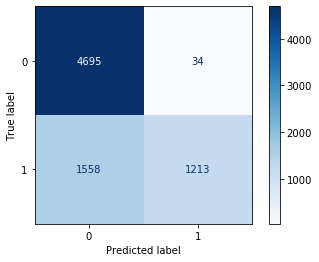

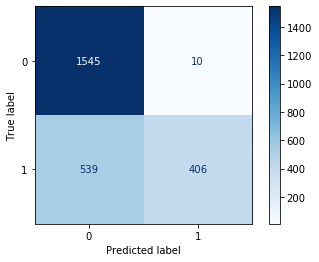

In [23]:
#Apply the modelfit function
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bayes)

### 3. Decision Tree

In [27]:
#Instansiate the model 
decisiontree = DecisionTreeClassifier(random_state=10)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4729
           1       1.00      1.00      1.00      2771

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0000
Train Set Precision: 1.0000
Train Set Recall: 1.0000
Train Set F1-Score: 1.0000


Test Score Results
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1555
           1       0.63      0.65      0.64       945

    accuracy                           0.73      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.73      0.73      0.73      2500

Test Set Accuracy: 0.7252
Test Set Precision: 0.6322
Test Set Recall: 0.6529
Test Set F1-Score: 0.6424


Graph 1: Train Set Confusion Matrix
Graph 2: Test Set Confusion Matrix


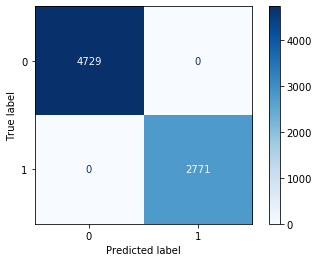

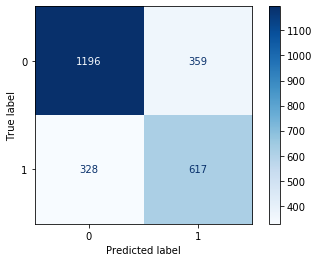

In [28]:
#Apply the model fit function 
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, decisiontree)